Animating the English house price ripple effect in Python
====================

Ricky Nathvani, April 2024

# Introduction

In May 2019, James Gleeson provided [a notebook on his GitHub](https://github.com/jgleeson/housing_analysis/blob/master/House_price_cycle.md) written in R demonstrating how to create an animated plot of England's house price cycle using Land Regsitry Data. In order to make this analysis accessible and usable by a wider segment of users (i.e. those better versed in Python than R) I have converted his analysis to Python below. Note that although [more recent data are available](https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-march-2019#download-the-data), to ensure replicability of the original results, I have used the same sources as the [original notebook](https://github.com/jgleeson/housing_analysis/blob/master/House_price_cycle.md).

With thanks to Daniel Dervén, Charlie Brummitt and Hassan Abedi for their excellent package [PyGam](https://github.com/dswah/pyGAM/tree/master), which provides the generalised additive model functionality needed to fit nice smoothed curves to our data in Python.

# Setup

Unlike the equivalent R libraries, common Python libraries like `pandas` and `seaborn` don't have in-built functions for adding smooth lines of fit using generalized additive models (which we'll need later on). Thankfully `pygam` can provide that for us if we install it first. We'll also need `pandas`, `seaborn`, `matplotlib` and `numpy` if you don't already have those, so go ahead and install them if need be.

In [1]:
!pip install pygam

Now we're ready to import all the libraries we'll need.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sns
import requests
import io
from IPython.display import display, Image
from pygam import LinearGAM, s
import numpy as np

## Data Import

For consistency and comparibility, I read in the same data as Jim's [original notebook](https://github.com/jgleeson/housing_analysis/blob/master/House_price_cycle.md) but be aware that there is more up-to-date data from the Land Registry's [UKHPI pages](https://landregistry.data.gov.uk/app/ukhpi/) you can use.

In [3]:
hpi = pd.read_csv("http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/Average-prices-2019-03.csv?utm_medium=GOV.UK&utm_source=datadownload&utm_campaign=average_price&utm_term=9.30_22_05_19")

## Data Preparation

Following Jim's analysis, we'll focus our attention on local authorities, and remove the unnecessary `Average_Price_SA` column. Note that our dataframe is now called `hpif`, following the original analysis. 

In [4]:
hpif = hpi[hpi['Area_Code'] < 'E10'].drop(columns=[col for col in hpi.columns if col.endswith('_SA')])

Now we'll sort the data by area and month (which is in the `Date` field), and then calculated the lagged prices by 3 years, so that we can calculate the average annual total percentage change in prices over three years (`Y3_price_change`). That's a bit of a mouthful but essentially we calculate the total percentage change over three years, then divide by three to get an effective year-on-year average change.

In [5]:
hpif = hpif.sort_values(['Area_Code', 'Date'])

hpif['lag_price'] = hpif.groupby('Area_Code')['Average_Price'].shift(36)

hpif['Y3_price_change'] = (hpif['Average_Price'] / hpif['lag_price'] - 1) / 3

Now, we'll also rank every local authority (in each month) from most to least expensive (which will be the x-axis of our housing ripple plot).

In [6]:
hpif['lag_price_rank'] = hpif.groupby('Date')['lag_price'].rank(method='dense', ascending=False)

Like the original, we'll filter the first three years (where we're unable to calculate "3 year changes" since we don't have data three years prior), and also remove the City of London which is highly volatile because it has low counts of sales.

In [7]:
hpif = hpif[hpif['Y3_price_change'].notnull() & (hpif['Region_Name'] != 'City of London')]

We'll also pull in some information on which region each local authority belongs to and add it to our dataframe using a look up file from ONS. In my version, I had to use Python's `requests` library because for some reason, pulling in the xlsx file directly with `read_csv` was causing an error! Nonetheless, the below seems to work. We'll also shorten one of the regional names and re-order them.

In [8]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/migrationwithintheuk/datasets/userinformationenglandandwaleslocalauthoritytoregionlookup/june2017/lookuplasregionew2017.xlsx"
response = requests.get(url)

if response.status_code == 200:
    lookup = pd.read_excel(io.BytesIO(response.content), skiprows=4)
    lookup.columns = lookup.columns.str.replace(' ', '_')
    hpif = hpif.merge(lookup, left_on='Area_Code', right_on='LA_code', how='left')
else:
    print(f"Failed to download the lookup file. Status code: {response.status_code}")
    
hpif.loc[hpif['Region_name'] == 'Yorkshire and The Humber', 'Region_name'] = 'Yorks and Humber'

region_order = ["North East", "North West", "Yorks and Humber", "East Midlands", "West Midlands", "East", "London", "South East", "South West"]
hpif['Region_name'] = pd.Categorical(hpif['Region_name'], categories=region_order, ordered=True)

## Plotting

To start we'll plot a scatter plot of price rank (x axis) against price change (y axis). This will be the basis for the animated ripple plot. First, I'm going to create a new colormap since it turns out, using the default `viridis` colormap in Matplotlib doesn't use the most contrasting colors by default. The little tweak below will fix this and make our plot more visually appealing.

In [9]:
n_regions = len(region_order)

colors = plt.cm.viridis(np.linspace(0, 1, n_regions))

color_map = dict(zip(region_order, colors))

Now we're ready to create our plot. Unlike R, we don't have the `stat_smooth` function to add a splined regression line in for legibility, so we'll improvise using `pygam` to fit a regression line separately and then plot it. We can control the number of splines, `n_splines` as we see fit, although at this stage it's only illustrative, as we'll build on this plot to animate the overall trend. I also do some tweaking with the positioning of text, titles and gridlines so our plot looks closer in appearance to the original.

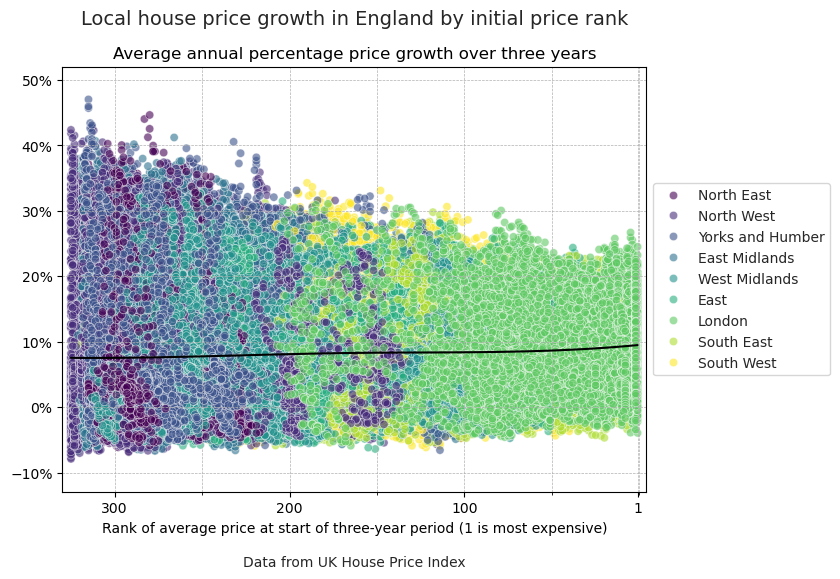

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_style("ticks", {'axes.grid': True})

data = hpif  # Use the entire dataset for the static plot

sns.scatterplot(data=data, x='lag_price_rank', y='Y3_price_change', hue='Region_name', palette=color_map, ax=ax, alpha=0.6)

# Fit a GAM with a spline term for 'lag_price_rank'
gam = LinearGAM(s(0, n_splines=5)).fit(data['lag_price_rank'], data['Y3_price_change'])

# Generate X values for prediction (cover the range of 'lag_price_rank')
x_pred = np.linspace(data['lag_price_rank'].min(), data['lag_price_rank'].max(), 100)
y_pred = gam.predict(x_pred)

# Plot the GAM spline fit
ax.plot(x_pred, y_pred, color='black')

ax.set_xlim(data['lag_price_rank'].max() + 5, data['lag_price_rank'].min() - 5)
ax.set_ylim(data['Y3_price_change'].min() - 0.05, data['Y3_price_change'].max() + 0.05)
ax.set_xlabel('Rank of average price at start of three-year period (1 is most expensive)')
ax.set_ylabel('')
ax.set_title('Average annual percentage price growth over three years')
ax.text(0.5, 1.1, 'Local house price growth in England by initial price rank', fontsize=14, ha='center', transform=ax.transAxes)
ax.text(0.5, -0.175, 'Data from UK House Price Index', ha='center', transform=ax.transAxes)

ax.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))

ax.set_xticks([1, 100, 200, 300])
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))

ax.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot to make space for the legend

plt.show()
# plt.savefig('static_housing_ripple_plot.png', dpi=300)

Because we're plotting all the years together, the graph is quite messy. This is where animating the plot to show each year as a frame comes in handy. Once again, achieving this in Python is a little more cumbersome, but we can use Matplotlib's `FuncAnimation` command to achieve something very similar to the original anlysis. We just need to create a function that takes a given date and returns the plot associated with that month of data. These will form the frames of our animation (and their code is basically the same as the plotting code above, only we filter the data for a given date).

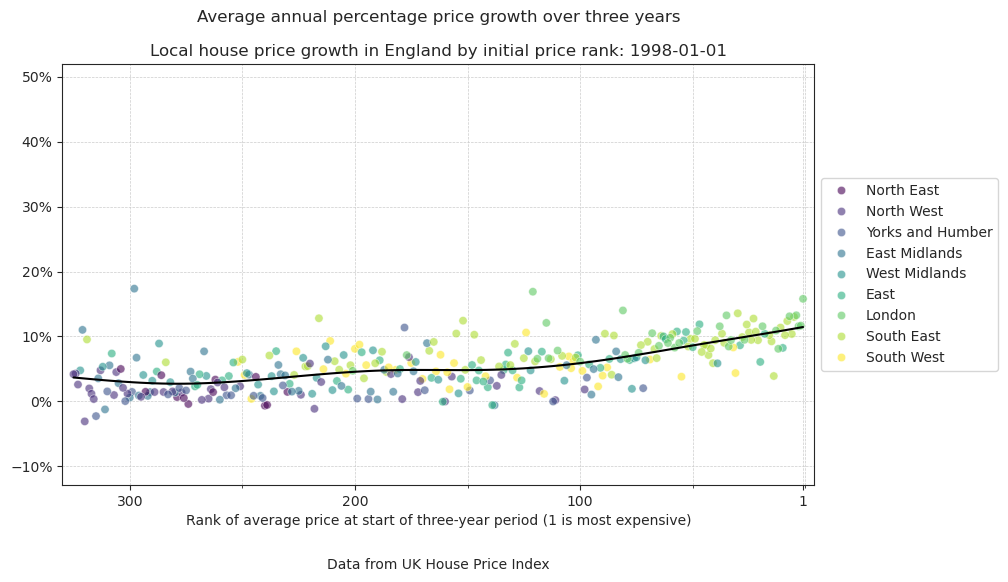

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_style("ticks", {'axes.grid': True})

def animate(date):
    ax.clear()
    data = hpif[hpif['Date'] == date]
    sns.scatterplot(data=data, x='lag_price_rank', y='Y3_price_change', hue='Region_name', palette=color_map, ax=ax, alpha=0.6)

    gam = LinearGAM(s(0, n_splines=10)).fit(data['lag_price_rank'], data['Y3_price_change'])
    
    x_pred = np.linspace(data['lag_price_rank'].min(), data['lag_price_rank'].max(), 100)
    y_pred = gam.predict(x_pred)
    
    ax.plot(x_pred, y_pred, color='black')

    ax.set_xlim(data['lag_price_rank'].max() + 5, data['lag_price_rank'].min() - 5)
    ax.set_ylim(hpif['Y3_price_change'].min() - 0.05, hpif['Y3_price_change'].max() + 0.05)
    ax.set_xlabel('Rank of average price at start of three-year period (1 is most expensive)')
    ax.set_ylabel('')
    ax.set_title(f'Local house price growth in England by initial price rank: {date}')
    ax.text(0.5, 1.1, 'Average annual percentage price growth over three years', fontsize=12, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.2, 'Data from UK House Price Index', ha='center', transform=ax.transAxes)

    ax.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))
    ax.set_xticks([1, 100, 200, 300])
    ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
    ax.grid(which='both', linestyle='--', linewidth=0.5)

dates = hpif['Date'].unique()
ani = FuncAnimation(fig, animate, frames=dates, interval=100)

plt.tight_layout(rect=[0, 0.1, 0.825, 0.9])

ani.save('animated_housing_ripple_plot.gif', writer='pillow')

And we're done! Note that `plt.show()` will only show the final frame, so to view the animated gif output inline in a Jupyter Notebook we can do the following instead:

In [12]:
from IPython.display import HTML
HTML('<img src="animated_housing_ripple_plot.gif">')